In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
import os
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import ImageFolder
from environment import StaticImgEnv
from PIL import Image
from matplotlib import pyplot as plot
import argparse
from ppo import PPO
from agent import Agent
import utils
import yaml

torch.set_printoptions(threshold=10000)

In [3]:
def read_yaml_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = read_yaml_config('config.yaml')

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

parser = argparse.ArgumentParser(description='trainer')
parser.add_argument('--lr', type=float, default=0.05, help='learning rate') 
parser.add_argument('--data_dir', default='archive', help='data directory')
parser.add_argument('--batch_size', type=int, default=16,help='batch size')
parser.add_argument('--ppo_rollout_batch_size', type=int, default=16,help='batch size')
parser.add_argument('--epochs', type=int, default=10, help='total epochs to run')
parser.add_argument('--verbose', type=int, default=1, help='verbose')
parser.add_argument('--loss_freq', type=int, default=50, help='loss print freq')
parser.add_argument('--eval_freq', type=int, default=1, help='eval freq')
parser.add_argument('--device', default='cuda', help='cuda')
parser.add_argument('--critic_param_path', default='./models/acmerge_resnet_value.pth', help='pretrained critic')
parser.add_argument('--actor_param_path', default='./models/acmerge_resnet_actor.pth', help='pretrained actor')
parser.add_argument('--disable_critic', default=False, help='no Critic')
trainer_args = parser.parse_args("")

parser = argparse.ArgumentParser(description='env')
parser.add_argument('--radius', type=int, default=112, help='fovea radius') 
parser.add_argument('--action_range', type=int, default=224, help='action range') 
parser.add_argument('--max_steps', type=int, default=15, help='max steps: -1 for unlimited') 
parser.add_argument('--grid_size', type=int, default=7, help='action space grid size')
parser.add_argument('--plot_freq', type=int, default=10, help='plot trajectory freq')
parser.add_argument('--target_num', type=int, default=18, help='how many targets to find')
env_args = parser.parse_args("")

print(config)


{'Environment': {'radius': 112, 'vision_radius': 500, 'action_range': 224, 'max_steps': 15, 'grid_size': 7, 'plot_freq': 10, 'target_num': 18}, 'PrefixResnet': {'depth': 6, 'kernel_size': '([3,3],[3,3],[3,3])', 'in_channel': 3, 'requires_grad': False}, 'PrefixCNN': {'img_size': 224, 'patch_size': 16, 'in_channel': 3, 'out_channel': 512, 'requires_grad': True, 'pretrained_model_path': ''}, 'ViTEncoder': {'embed_dim': 512, 'depth': 24, 'num_heads': 16, 'mlp_ratio': 4.0, 'qkv_bias': False, 'qk_scale': False, 'drop_rate': 0.2, 'attn_drop_rate': 0.3, 'drop_path_rate': 0.3, 'num_classes': 100}, 'ViTDecoder': {'embed_dim': 256, 'depth': 8, 'num_heads': 16, 'mlp_ratio': 4.0, 'qkv_bias': False, 'qk_scale': False, 'drop_rate': 0.2, 'attn_drop_rate': 0.2, 'drop_path_rate': 0.2}}


In [4]:
dataset_root="COCOSearch18"
with open(os.path.join(dataset_root,
               'coco_search18_fixations_TP_train_split1.json'#'coco_search18_fixations_TP_train.json'
               )) as json_file:
    human_scanpaths_train = json.load(json_file)
    
with open(os.path.join(dataset_root,
               'coco_search18_fixations_TP_validation_split1.json'#'coco_search18_fixations_TP_validation.json'
               )) as json_file:
    human_scanpaths_valid = json.load(json_file)

'''
max=0
for dict in human_scanpaths_train:
    print(dict)
    if dict['length']>=max:
        max=dict['length']
print(max)
'''

dataset=utils.COCOSearch18(json=human_scanpaths_train,root='COCOSearch18/images',test=True)
training_loader=DataLoader(dataset,batch_size=trainer_args.batch_size,shuffle=True,num_workers=8)
env=StaticImgEnv(env_args=config['Environment'], show_plot=True)
agent=Agent(device=trainer_args.device,actor_path=trainer_args.actor_param_path,critic_path=trainer_args.critic_param_path,\
            grid_size=config['Environment']['grid_size'],disable_critic=trainer_args.disable_critic,recog_threshold=0.5)
ppo=PPO(agent,lr=0.01,betas=[0.9,0.999],clip_param=0.2,num_epoch=1,batch_size=trainer_args.ppo_rollout_batch_size,\
        value_coef=0.5,entropy_coef=0.8,drop_failed=False,vgg_backbone_fixed=True) #lr=0.01 clip=0.2 value_coef=1
#for i in agent.named_children():
#     print(i)

#print(agent.acmerge.value_read_out.weight[0])

<All keys matched successfully>


[1/1]: VLoss: 11.694, PLoss: 0.501, loss: -1.343
[1/1]: VLoss: 13.750, PLoss: 0.151, loss: -1.675
[1/1]: VLoss: 11.760, PLoss: 1.381, loss: -0.455
[1/1]: VLoss: 13.867, PLoss: 0.592, loss: -1.243
[1/1]: VLoss: 15.153, PLoss: 0.146, loss: -1.657
[1/1]: VLoss: 13.353, PLoss: 3.751, loss: 1.916
[1/1]: VLoss: 13.256, PLoss: 0.702, loss: -1.138
[1/1]: VLoss: 12.831, PLoss: 0.421, loss: -1.411
[1/1]: VLoss: 13.129, PLoss: 0.443, loss: -1.441
torch.Size([15, 2])


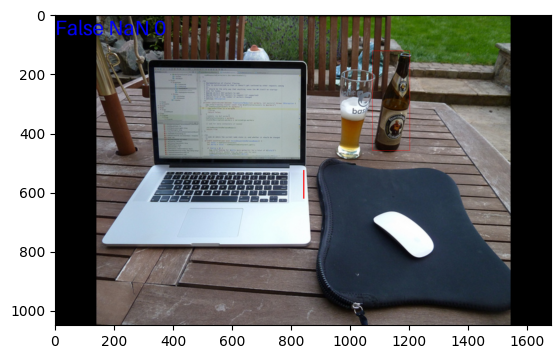

torch.Size([15, 2])


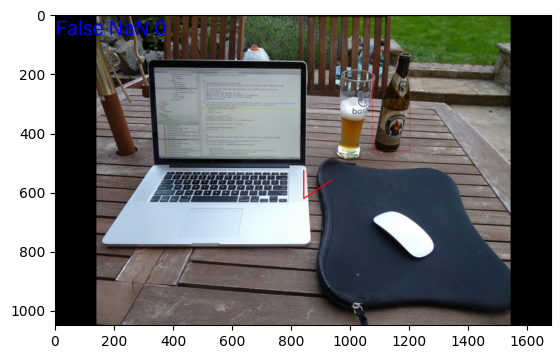

torch.Size([15, 2])


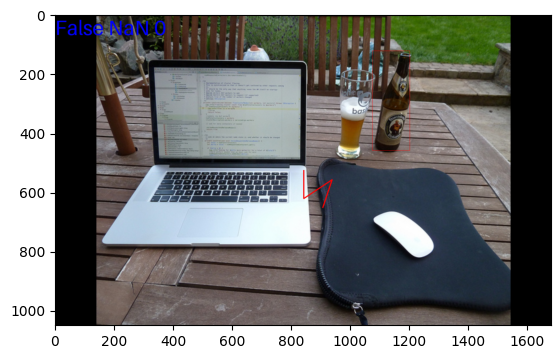

torch.Size([15, 2])


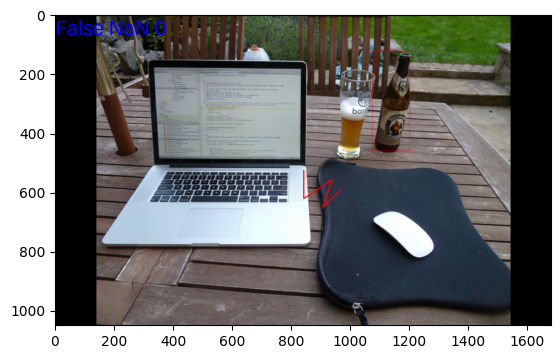

torch.Size([15, 2])


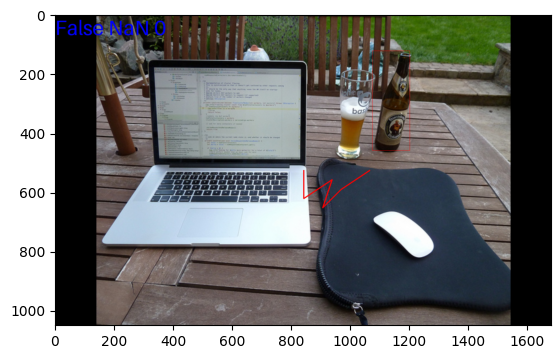

torch.Size([15, 2])


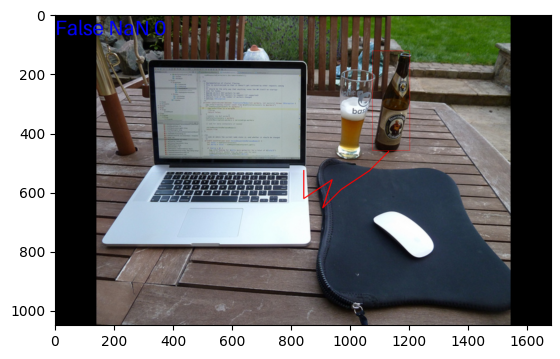

torch.Size([15, 2])


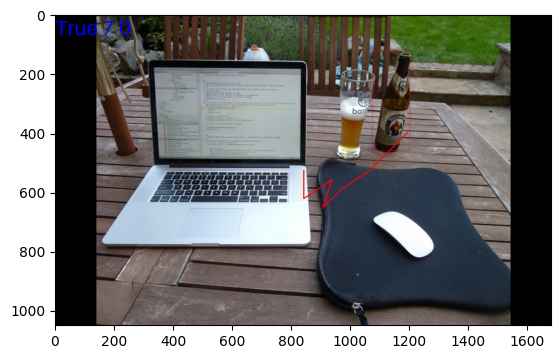

torch.Size([15, 2])


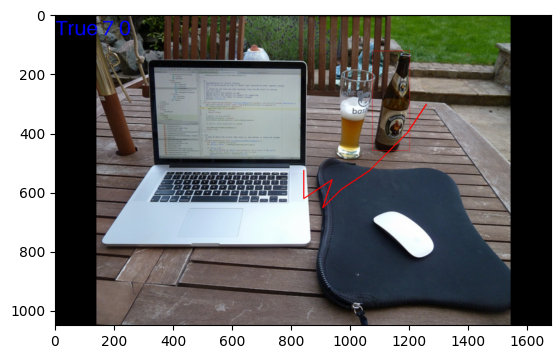

torch.Size([15, 2])


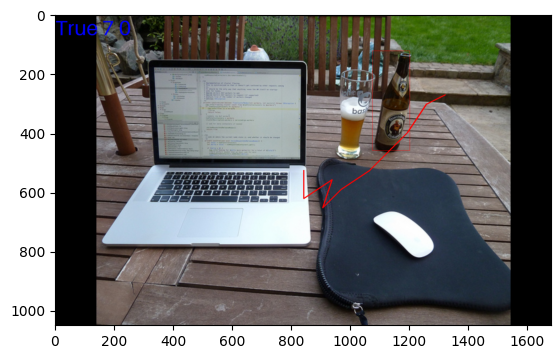

torch.Size([15, 2])


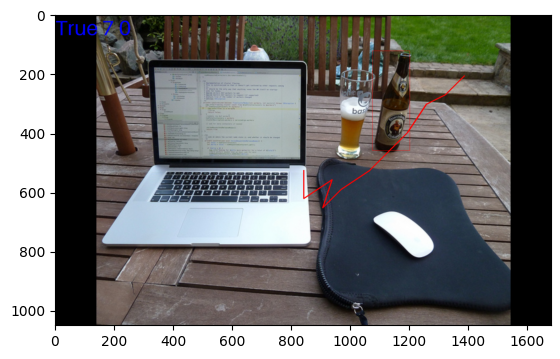

torch.Size([15, 2])


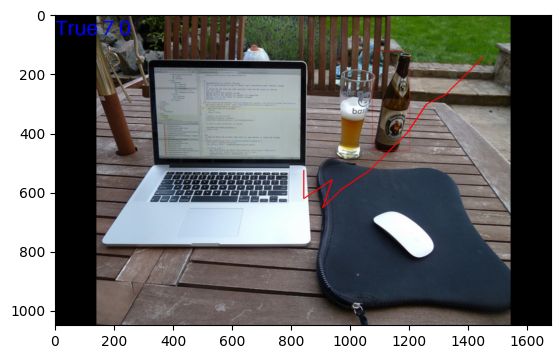

torch.Size([15, 2])


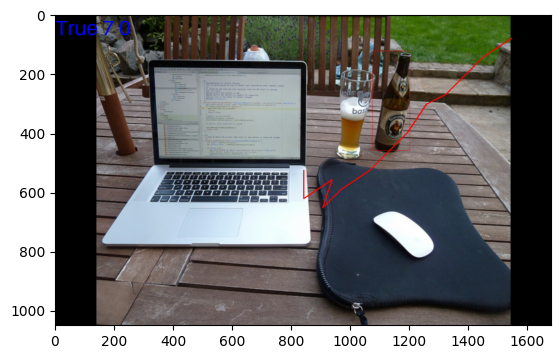

torch.Size([15, 2])


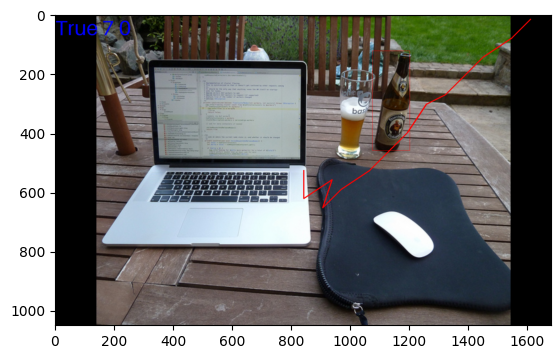

torch.Size([15, 2])


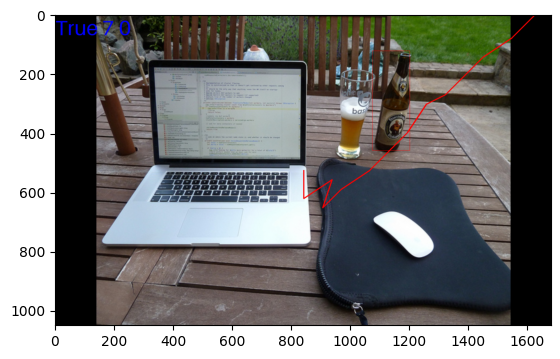

[1/1]: VLoss: 16.668, PLoss: 0.047, loss: -1.825
[1/1]: VLoss: 17.279, PLoss: -0.289, loss: -2.115
[1/1]: VLoss: 13.496, PLoss: 0.337, loss: -1.490
[1/1]: VLoss: 15.928, PLoss: 0.460, loss: -1.368
[1/1]: VLoss: 13.457, PLoss: 1.072, loss: -0.818
[1/1]: VLoss: 13.936, PLoss: 0.208, loss: -1.618
[1/1]: VLoss: 13.468, PLoss: 0.726, loss: -1.123
[1/1]: VLoss: 15.031, PLoss: 0.128, loss: -1.705
[1/1]: VLoss: 14.743, PLoss: 0.295, loss: -1.536
[1/1]: VLoss: 12.966, PLoss: 1.092, loss: -0.719
torch.Size([15, 2])


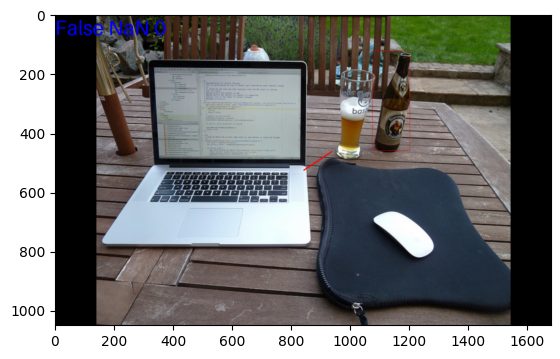

torch.Size([15, 2])


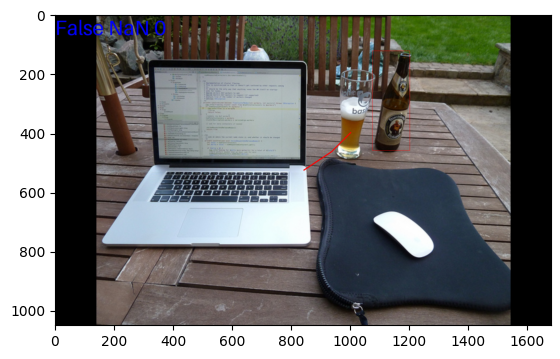

torch.Size([15, 2])


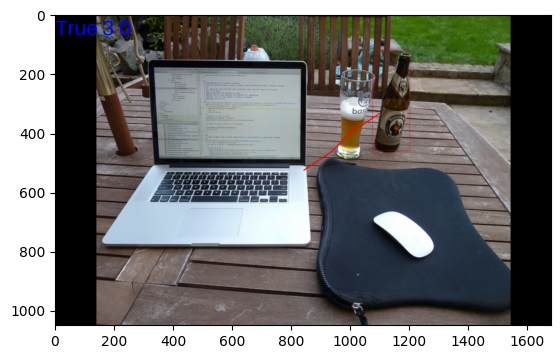

torch.Size([15, 2])


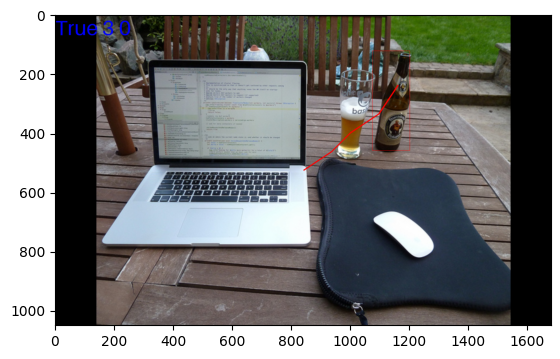

torch.Size([15, 2])


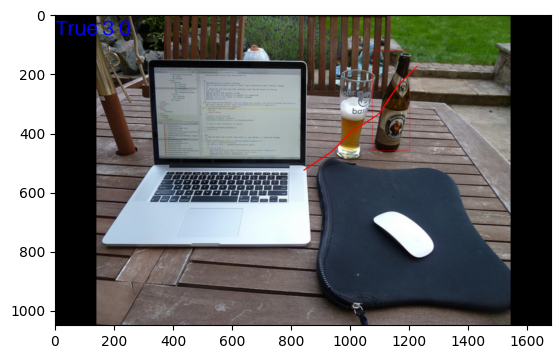

torch.Size([15, 2])


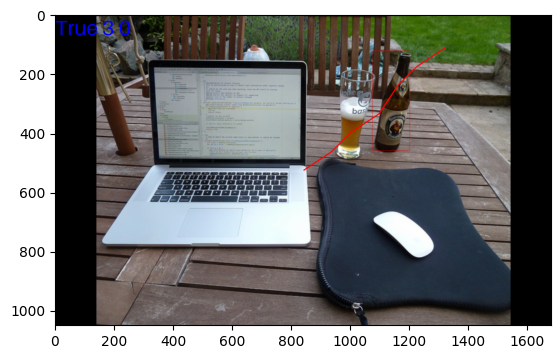

torch.Size([15, 2])


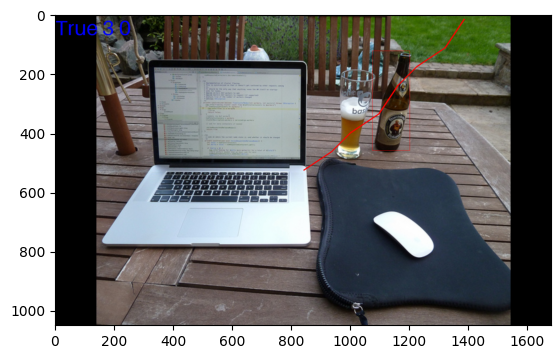

torch.Size([15, 2])


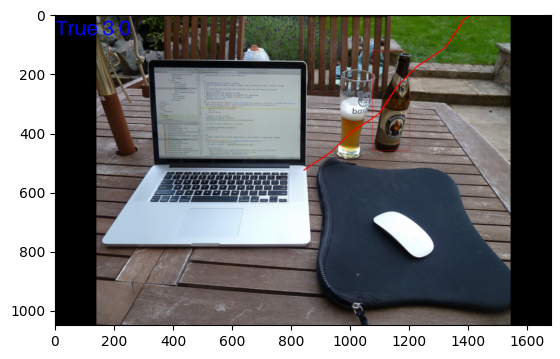

torch.Size([15, 2])


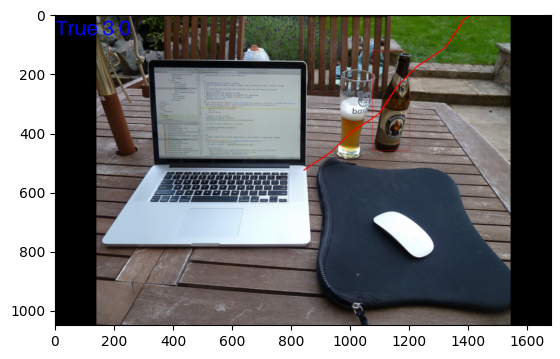

torch.Size([15, 2])


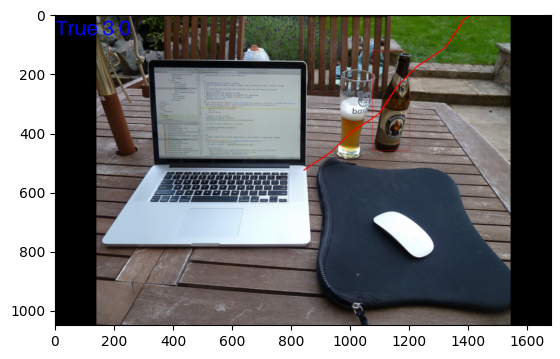

torch.Size([15, 2])


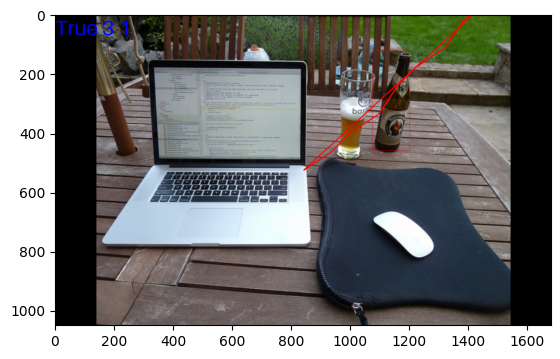

torch.Size([15, 2])


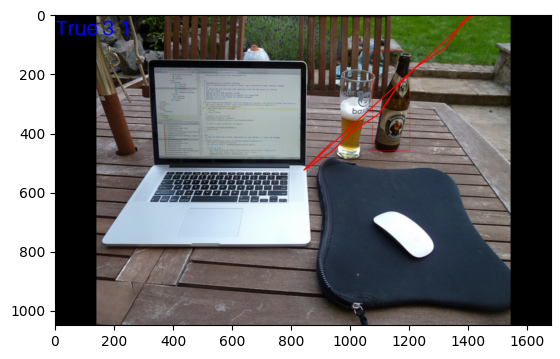

torch.Size([15, 2])


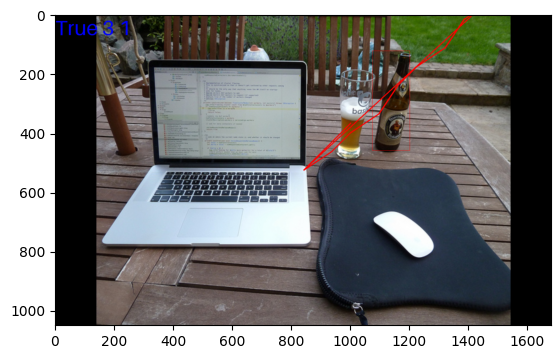

torch.Size([15, 2])


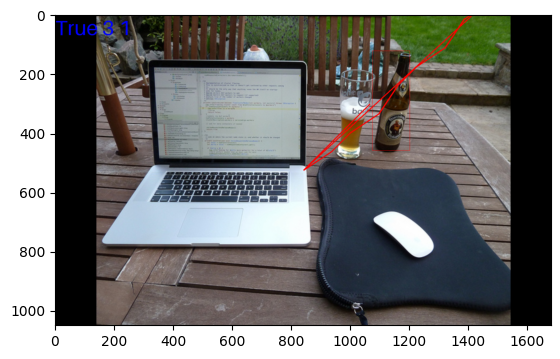

[1/1]: VLoss: 15.645, PLoss: 0.143, loss: -1.665
[1/1]: VLoss: 12.818, PLoss: 0.198, loss: -1.681
[1/1]: VLoss: 14.520, PLoss: -0.116, loss: -1.968
[1/1]: VLoss: 12.951, PLoss: 0.642, loss: -1.189
[1/1]: VLoss: 12.466, PLoss: 0.146, loss: -1.771
[1/1]: VLoss: 13.180, PLoss: 0.689, loss: -1.195
[1/1]: VLoss: 13.147, PLoss: 0.400, loss: -1.463
[1/1]: VLoss: 13.042, PLoss: 0.245, loss: -1.613
[1/1]: VLoss: 12.776, PLoss: 0.504, loss: -1.276
[1/1]: VLoss: 14.383, PLoss: 0.446, loss: -1.405
torch.Size([15, 2])


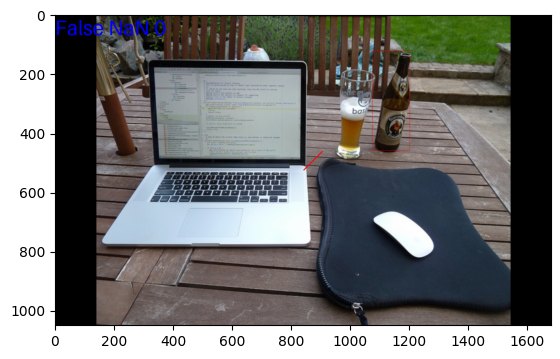

torch.Size([15, 2])


KeyboardInterrupt: 

In [8]:
#for child in agent.critic.vgg.features:
#    print('ReLU' in str(child))
#raise ValueError
import time
def tensor_to_PIL(tensor):
    unloader = v2.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image
start=time.time()
for epoch in range(trainer_args.epochs):
    for idx, (img, target_id, fixations, correct, bbox) in enumerate(training_loader):
        env.set_data(img,target_id, bbox) #bbox->target bbox [x,y,w,h]
        with torch.no_grad():
            trajs_all=utils.collect_trajs(env,agent,max_traj_length=env_args.max_steps)
        utils.process_trajs(trajs_all,gamma=0.9,epistemic_coef=2)
        '''Be cautious the trajectories collected->[traj_length,batch_size,...]'''
        #for item in trajs_all:
        #    print(item,trajs_all[item].shape)
        rollouts=utils.RolloutStorage(trajs_all)
    
        loss=ppo.update(rollouts)
    
        #for i, sample in enumerate(data_generator):

torch.cuda.empty_cache()
end=time.time()
print(end-start)

In [ ]:
from PIL import Image, ImageDraw
def tensor_to_PIL(tensor):
    unloader = v2.ToPILImage()

    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image
bg=torch.zeros((1,3,224,224))
from torchvision.transforms import v2
#top: int, left: int, height: int, width: int
img=v2.functional.crop(bg,0,2,100,100)
img=tensor_to_PIL(img)
#img.show()
draw = ImageDraw.Draw(img)
fixations=[[1,2],[20,20]]
fixations=[tuple(item) for item in fixations]
print(fixations)
draw.point(fixations,fill='red')
img.show()

In [ ]:
from torch.distributions import MultivariateNormal,Categorical
import torch.nn.functional as F
act_batch=torch.randint(-100,100,(64,2))
#m = MultivariateNormal(act_batch, torch.eye(2))
#m.sample()
logits=F.softmax(abs(torch.randn(5,225)+1),dim=-1)
print(logits)
mvn = Categorical(logits)
act_batch=mvn.sample()
print(act_batch.shape)

In [ ]:
import torch.nn as nn
a=torch.rand((14,64,18))
b=torch.rand((14,64,18))
entropy=nn.BCELoss(reduction='none')
#print(a,b)
c=torch.concatenate((a[:32],b[32:]),dim=0)
print(entropy(b,c).mean(-1).shape)

d=torch.tensor([0,1.0,0])
e=torch.tensor([1.0,0,1.0])
#print(entropy(d,e).mean(-1))
# tensor(0.9964)

In [ ]:
a=torch.zeros((16,18,100))
b=torch.randint(low=0,high=17,size=(16,))
print(b)
a[torch.arange(a.shape[0]),b].shape